# Assistants API (Python SDK)

[Assistants API](https://learn.microsoft.com/azure/ai-services/openai/concepts/assistants) を使うと、データを分析し、ソリューションを提案し、タスクを自動化できる、高度な Copilot のようなエクスペリエンスを備えたアプリケーションを簡単に作成できます。

ステートレスな Chat Completions API であるのに比べて、ステートフルな Assistants API は、自動的に管理される永続的なスレッドがサポートされます。つまり、会話状態管理システムを開発し、モデルのコンテキスト ウィンドウの制約を回避する必要がなくなります。さらにアシスタントは、必要に応じて複数のツールに並列アクセスすることもできます。 以下のツールが利用可能です。

- Code Interpreter
- Function calling（関数呼び出し）

In [ ]:
!pip install --upgrade openai

In [ ]:
import openai
openai.__version__

In [ ]:
from dotenv import load_dotenv
load_dotenv()

#from openai import OpenAI
from openai import AzureOpenAI

import os
import json

# IF YOU ARE USING OPENAI, UNCOMMENT THE FOLLOWING LINES
#client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "Your OpenAI API Key"))

# IF YOU ARE USING AZURE OPENAI, UNCOMMENT THE FOLLOWING LINES
#os.environ["AZURE_OPENAI_API_KEY"] = "Your OpenAI API Key"
#os.environ["AZURE_OPENAI_ENDPOINT"] = "https://<Your OpenAI Service>.openai.azure.com/"

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-02-15-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)

## アシスタントの作成

In [ ]:
tools_list = [
    {
        "type": "code_interpreter"
    },
    {
        "type": "function",
        "function": {
            "name": "search_hotpepper_shops",
            "description": "ホットペッパーグルメAPIを利用し、キーワードや個室の有無などのオプションフィルターで飲食店を検索できます。",
            "parameters": {
                "type": "object",
                "properties": {
                    "keyword": {
                        "type": "string",
                        "description": "飲食店を検索するためのキーワード。店名、住所、駅名、お店ジャンルなどを指定できる。ユーザーメッセージから検索キーワードとなる文字を抽出して検索クエリーにしてください。例: ###大阪駅 和食###"
                    },
                    "private_room": {
                        "type": "integer",
                        "description": "個室ありの店舗のみを検索, 0:絞り込まない, 1:絞り込む。オプション",
                        "enum": [0, 1]
                    }
                },
                "required": ["keyword"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "search_vacant_hotels",
            "description": "楽天トラベルのAPIを使って、場所、チェックイン日、チェックアウト日、予算、大人の人数など、さまざまなフィルターで空室ホテルを検索できます。",
            "parameters": {
                "type": "object",
                "properties": {
                    "latitude": {
                        "type": "number",
                        "description": "ホテル検索場所の緯度(WGS84), ex:35.6065914"
                    },
                    "longitude": {
                        "type": "number",
                        "description": "ホテル検索場所の経度(WGS84), ex:139.7513225"
                    },
                    "searchRadius": {
                        "type": "number",
                        "description": "緯度経度検索時の検索半径(単位km), 0.1 to 3.0"
                    },
                    "checkinDate": {
                        "type": "string",
                        "description": "yyyy-MM-dd 形式のチェックイン日。年の指定がない場合は2024年を指定する。"
                    },
                    "checkoutDate": {
                        "type": "string",
                        "description": "yyyy-MM-dd 形式のチェックアウト日。年の指定がない場合は2024年を指定する。"
                    },
                    "maxCharge": {
                        "type": "integer",
                        "description": "上限金額, int 0 to 999999999"
                    },
                    "adultNum": {
                        "type": "integer",
                        "description": "宿泊者数, int 1 to 99"
                    }
                },
                "required": ["latitude", "longitude", "searchRadius", "checkinDate", "checkoutDate"]
            }
        }
    },
   {
        "type": "function",
        "function": {
            "name": "searchTransportation",
            "description": "交通機関の検索と予約を行います。",
            "parameters": {
                "type": "object",
                "properties": {
                    "transportType": {
                        "type": "string",
                        "description": "交通機関の種類（例：飛行機、列車、バスなど）"
                    },
                    "origin": {
                        "type": "string",
                        "description": "出発地点"
                    },
                    "destination": {
                        "type": "string",
                        "description": "目的地点"
                    },
                    "departureDate": {
                        "type": "string",
                        "description": "出発日（YYYY-MM-DD形式）"
                    },
                    "returnDate": {
                        "type": "string",
                        "description": "帰りの日付（往復の場合）"
                    },
                    "passengers": {
                        "type": "integer",
                        "description": "乗客の人数"
                    }
                },
                "required": [
                    "transportType",
                    "origin",
                    "destination",
                    "departureDate",
                    "passengers"
                ]
            }
        }
    }
]


In [ ]:
# Create an assistant
assistant = client.beta.assistants.create(
    name="Travel Assistant",
    instructions="""
あなたは Contoso 社の社員の出張を支援するためのアシスタントです。あなたは以下の業務を遂行します。
 - 旅程を作成します
 - ホテルを検索したり予約します
 - 交通機関を検索します
 - 出張で行くべきレストランや居酒屋を提案します
 - 出張にかかる概算費用を計算します

#制約事項
 - ユーザーからのメッセージは日本語で入力されます
 - ユーザーからのメッセージから忠実に情報を抽出し、それに基づいて応答を生成します。
 - ユーザーからのメッセージに勝手に情報を追加したり、不要な改行文字 \n を追加してはいけません

""",
    tools=tools_list,
    model="gpt-4-1106-preview" #You must replace this value with the deployment name for your model.
)

In [ ]:
assistant

## アシスタントを一覧表示
使用するアシスタントを一覧表示します。

In [ ]:
assistants = client.beta.assistants.list()
print(assistants.model_dump_json(indent=2))

In [ ]:
for assistant in assistants.data:
    print(f"{assistant.id}: {assistant.name}")

## アシスタントを取得
特定のアシスタントにアクセスするには `assistant_id` を指定することで Assistant オブジェクトを取得できます。

In [ ]:
assistant = client.beta.assistants.retrieve(assistant_id="Your Assistant ID") 
print(assistant.model_dump_json(indent=2))

### アシスタントをアップデート
途中でアシスタントの設定を修正したい場合、`assistant_id` を指定してアップデートできる。

In [ ]:
assistant = client.beta.assistants.update(assistant_id="Your Assistant ID",
    name="Travel Assistant",
    instructions="""
あなたは Contoso 社の社員の出張を支援するためのアシスタントです。あなたは以下の業務を遂行します。
 - 旅程を作成します
 - ホテルを検索したり予約します
 - 交通機関を検索します
 - 出張で行くべきレストランや居酒屋を提案します
 - 出張にかかる概算費用を計算します
 
#制約事項
 - ユーザーからのメッセージは日本語で入力されます
 - ユーザーからのメッセージから忠実に情報を抽出し、それに基づいて応答を生成します。
 - ユーザーからのメッセージに勝手に情報を追加したり、不要な改行文字 \n を追加してはいけません

""",
    tools=tools_list,
    model="gpt-4-0125-preview" #You must replace this value with the deployment name for your model.
    )

assistant

## スレッドを作成する
スレッドとメッセージは、アシスタントとユーザーの会話セッションを表します。スレッドに保存できるメッセージの数に制限はありません。メッセージのサイズがモデルのコンテキストウィンドウを超えると、スレッドはコンテキストウィンドウに収まるできるだけ多くのメッセージを含めようとし、最も古いメッセージを削除します。

このようにメッセージの初期リストを持つスレッドを作成することができます：


In [ ]:
# Create a thread
thread = client.beta.threads.create()
print(thread.model_dump_json(indent=2))

## スレッドの取得
特定のスレッドにアクセスするには、`thread_id` を指定することでスレッドオブジェクトを取得できます。

In [ ]:
thread = client.beta.threads.retrieve(thread_id="Your Thread ID")
print(thread)

メッセージにはテキスト、画像、ファイルを含めることができます。現時点では、ユーザーが作成したメッセージに画像ファイルを含めることはできませんが、将来的に対応する予定です。また、メッセージのファイルサイズとトークンの上限は、アシスタントの場合と同じです（ファイルサイズの上限は512MB、トークンの上限は2,000,000）。

## スレッドメッセージの一覧表示

In [ ]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

In [ ]:
for message in messages.data:
    print(f"{message.id}: {message.content[0].text.value}")

## Helper Functions 

In [ ]:
#Run の非同期処理が完了するまでそのステータスを監視し続けるためのループを実装
import time
def wait_on_run(run, thread_id):
    # 最初のステータス出力
    print(f"Initial Run status: {run.status}")
    while run.status == "queued" or run.status == "in_progress":
        run = client.beta.threads.runs.retrieve(
            thread_id=thread_id,
            run_id=run.id,
        )
        print(f"Run status: {run.status}")
        time.sleep(1)
    # ループ終了後の最終ステータス出力
    print(f"Final Run status: {run.status}\n")
    return run

In [ ]:
#指定されたスレッドにユーザーメッセージを送信し、その後に同じスレッドで Run を開始
def submit_message(assistant_id, thread_id, user_message):
    client.beta.threads.messages.create(
        thread_id=thread_id, role="user", content=user_message
    )
    return client.beta.threads.runs.create(
        thread_id=thread_id,
        assistant_id=assistant_id,
    )
#指定されたスレッドのメッセージを取得
def get_response(thread_id):
    return client.beta.threads.messages.list(thread_id=thread_id, order="asc")

In [ ]:
# 新しいスレッドを作成し、メッセージを送信する
def create_thread_and_run(user_input):
    thread = client.beta.threads.create()
    run = submit_message(assistant.id, thread.id, user_input)
    return thread, run

# すでに作成されたスレッドにメッセージを送信する
def create_run(user_input):
    run = submit_message(assistant.id, thread.id, user_input)
    return run

In [ ]:
# Pretty printing helper
# メッセージのリストを受け取り、それらの role とテキスト内容を整形して出力
def pretty_print(messages):
    print("# Messages")
    for m in messages:
        print(f"{m.role}: {m.content[0].text.value}")
    print()

### Run

作成したスレッドが、先ほど作成したアシスタントとどのように関連付けられているかに注目してください。**スレッドはアシスタントから独立して存在**します。

指定されたスレッドに対してアシスタントから完了を得るには、Run を作成する必要があります。Run を作成すると、アシスタントはスレッドのメッセージを見て、1つの応答を追加するか、ツールを使用してアクションを実行する必要があるか判断します。

> ***注***：
> Assistants API では、Run によってアシスタントが 1 つまたは複数のツールを使用し、スレッドに複数のメッセージを追加する可能性があります。

Run を作成しましょう。`threads.runs.create` は `submit_message` ヘルパー関数の中で記述しています。アシスタントとスレッドの両方を指定する必要があります。


In [ ]:
#run = create_run("2/10に大阪駅近辺で2人で和食の居酒屋を探しています")
run = create_run("2/14に大阪駅近辺で1人で泊まれるビジネスホテルを探しています。")
#run = create_run("2/10に東京駅から大阪駅まで新幹線のチケットを探しています。")
#run = create_run("2/10から2/12まで大阪に出張します。2/10の10:00にイベント会場に到着する必要があります。出張のプランを作成してください。")

run = wait_on_run(run, thread.id)
# スレッドのメッセージ一覧を出力 client.beta.threads.messages.list
pretty_print(get_response(thread.id))


Chat Completions API で完了を作成するのとは異なり、**Run の作成は非同期操作** です。Runのメタデータはすぐに返され、そのメタデータには `status` が含まれます。アシスタントが操作（ツールの使用やメッセージの追加など）を実行すると、`status`は更新されます。

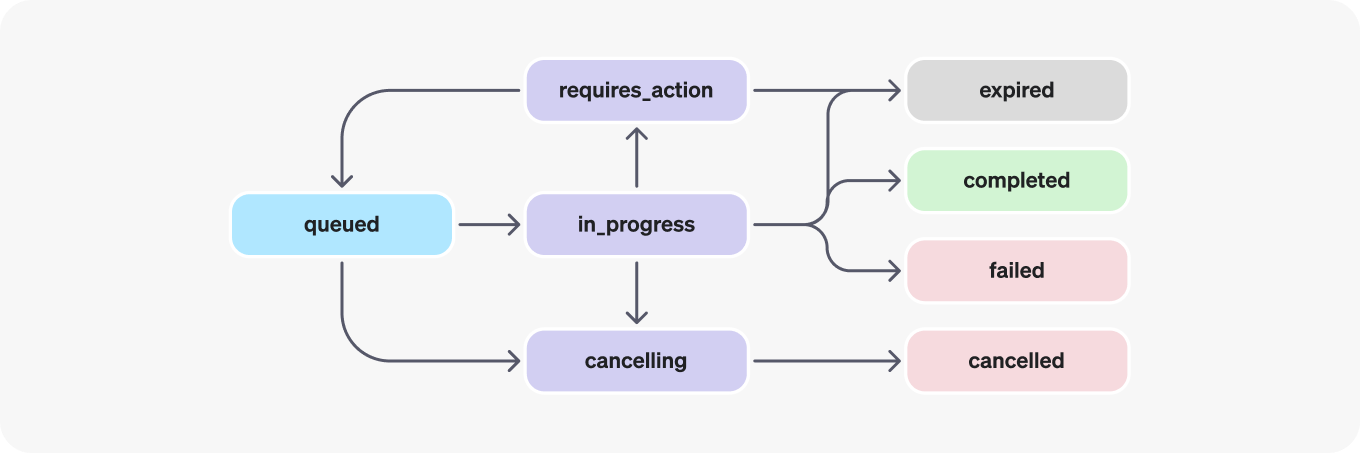

アシスタントの処理がいつ完了したかを知るには、ループ内で Run をポーリングします。(ここでは `queued` または `in_progress` ステータスのみをチェックしていますが、実際にはランが [さまざまなステータス変更](https://platform.openai.com/docs/api-reference/runs/object#runs/object-status) を受けることがあります。(これらはステップと呼ばれ、後で説明する）。


`required_action` フィールドは、Tool が実行され、その出力がアシスタントに送信されるのを待っていることを示します。

> 注意
> この場合、ツールの呼び出しは1つだけですが、実際にはアシスタントが複数のツールを呼び出すこともあります。


### Messages
Run が完了したので、スレッドのメッセージを一覧表示して、アシスタントが追加したメッセージを確認できます。
ご覧の通り、メッセージは逆順に並んでいます。これは最新の結果が常に最初の `ページ` に表示されるようにするためです（結果はページ分割できるので）。これはチャット完了 API のメッセージとは逆の順序なので、注意してください。


In [ ]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

## Tools
Assistants API の重要な機能は、Code Interpreter、検索、カスタム関数などの Tool をアシスタントに装備できることです。ツールは最大 128 個まで登録できます。

アシスタントが正確に何をしているのかもっと詳しく知りたい場合は、Run の**ステップ**を見る必要があります。

### ステップ
Run の `status` が `requires_action` になると Run の実行が一時停止され、Tool の実行結果の待ち状態となります。この時、当該 Run の内部ではどうなっているのでしょうか。Run の下位の実行単位である Run step を参照してみましょう。

In [ ]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id, run_id=run.id, order="asc"
)

print(run_steps.model_dump_json(indent=2))

呼ぶべき Tool は `step_details` の中にあります。

In [ ]:
for step in run_steps.data:
    step_details = step.step_details
    print(step_details.model_dump_json(indent=2))

### tool_call オブジェクトの取得
Assistant API の Function calling はあくまで呼ぶべき関数の選択とパラメータの抽出のみしか行いません。**実際の関数実行はアプリケーション側で行います**。関数の実行に必要な `name` と `arguments` を解析して必要な情報を抽出しましょう。


In [ ]:
tool_call = run.required_action.submit_tool_outputs.tool_calls[0]
name = tool_call.function.name
arguments = json.loads(tool_call.function.arguments)
arguments

## 空きホテルを検索
`tool_call` オブジェクトから得られた検索パラメータを `search_vacant_hotels` 関数のパラメータとして流し込みます。

In [ ]:
import requests
#https://webservice.rakuten.co.jp/documentation/vacant-hotel-search
def search_vacant_hotels(applicationId, latitude, longitude, searchRadius, checkinDate, checkoutDate, maxCharge=50000, adultNum=1, page=1, hits=2, response_format='json'):
    base_url = "https://app.rakuten.co.jp/services/api/Travel/VacantHotelSearch/20170426"
    params = {
        "applicationId": applicationId,
        "format": response_format,
        "page": page,
        "hits": hits,
        "latitude": latitude, # ex:35.6065914
        "longitude": longitude, # ex:139.7513225
        "searchRadius": searchRadius,  #緯度経度検索時の検索半径(単位km), 0.1 to 3.0
        "datumType": 1, # WGS84
        "checkinDate": checkinDate, # yyyy-MM-dd
        "checkoutDate": checkoutDate, # yyyy-MM-dd
        "maxCharge": maxCharge, # 上限金額, int 0 to 999999999
        "adultNum": adultNum # 宿泊者数, int 1 to 99
    }
    
    response = requests.get(base_url, params=params)
    
    # レスポンス形式に応じて結果を処理
    if response_format == 'json':
        response_data = response.json()

        if 'error' in response_data:
            error_description = response_data.get('error_description', 'No error description provided.')
            error = response_data.get('error', 'Unknown error')
            
            # エラーメッセージを処理（またはログに記録）
            print(f"Error: {error}, Description: {error_description}")
            
            # エラー情報を含むレスポンスオブジェクトまたはメッセージを返す
            return {"error": error, "error_description": error_description}
        else:
            # エラーがない場合は、通常通りレスポンスデータを返す
            hotels = []
            for hotel_group in response_data["hotels"]:
                h = hotel_group["hotel"][0]["hotelBasicInfo"]
                rooms = []
                for item in hotel_group["hotel"][1:]:
                    if "roomInfo" in item:
                        roomplans = {"roomName": item["roomInfo"][0]["roomBasicInfo"]["roomName"],
                            "stayDate": item["roomInfo"][1]["dailyCharge"]["stayDate"],
                            "rakutenCharge": item["roomInfo"][1]["dailyCharge"]["rakutenCharge"]}
                        rooms.append(roomplans)

                hotel = {"hotelNo": h["hotelNo"],
                        "hotelName": h["hotelName"],
                        "hotelSpecial": h["hotelSpecial"],
                        "access": h["access"],
                        "reviewAverage": h["reviewAverage"],
                        "hotelInformationUrl": h["hotelInformationUrl"],
                        "roomplans": rooms}
                hotels.append(hotel)
            
            return hotels
    else:
        return response.text  # XML形式の場合は、レスポンスのテキストをそのまま返す

applicationId = "Your API key"  # APIキーを設定
latitude = arguments.get("latitude", None)
longitude = arguments.get("longitude", None)
searchRadius = arguments.get("searchRadius", None)
checkinDate = arguments.get("checkinDate", "2024-02-14")
checkoutDate = arguments.get("checkoutDate", "2024-02-15")
maxCharge = arguments.get("maxCharge", 50000)
adultNum = arguments.get("adultNum", 1)

response = search_vacant_hotels(applicationId, latitude, longitude, searchRadius, checkinDate, checkoutDate, maxCharge, adultNum, response_format='json')
response

In [ ]:
input = {"answer": response, "success": True}

### ツール出力の送信
それでは、レスポンスをアシスタントに送信してみましょう。先ほど解析した `tool_call` で見つかった `tool_call` ID が必要です。また、レスポンスの `list` を `str` にエンコードする必要があります。


In [ ]:
run = client.beta.threads.runs.submit_tool_outputs(
    thread_id=thread.id,
    run_id=run.id,
    tool_outputs=[
        {
            "tool_call_id": tool_call.id,
            "output": json.dumps(input),
        }
    ],
)

run = wait_on_run(run, thread.id)
# スレッドのメッセージ一覧を出力 client.beta.threads.messages.list
pretty_print(get_response(thread.id))

これでもう一度 Run が完了するのを待ち、Run ステップをチェックします。


In [ ]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id, run_id=run.id, order="asc"
)

for step in run_steps.data:
    step_details = step.step_details
    print(step_details.model_dump_json(indent=2))


2つのステップの `step_details` を見ることができます。

1. `tool_calls` (複数形。1つのステップで複数になる可能性があるため)
2. メッセージの作成

最初のステップは `tool_calls` で、特に `code_interpreter` や `function` を使っています。

- `input` はツールが呼ばれる前に生成された Python コード
- Tool を実行した結果の `output`

2つ目のステップは `message_creation` で、結果をユーザーに伝えるためにスレッドに追加された `message` が含まれます。

In [ ]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

# 2. レストラン検索

In [ ]:
run = create_run("有楽町駅近辺でイタリアンのレストランを探しています")
#run = create_run("2/10 なにわ亭で15000円、2/11 朝食3000円、新幹線代は片道で14,920円でした。合計金額を計算してください")
#run = create_run("2/10に大阪駅近辺で1人で泊まれるビジネスホテルを探しています。")
#run = create_run("2/10に東京駅から大阪駅まで新幹線のチケットを探しています。")
#run = create_run("2/10から2/12まで大阪に出張します。2/10の10:00にイベント会場に到着する必要があります。出張のプランを作成してください。")

run = wait_on_run(run, thread.id)
# スレッドのメッセージ一覧を出力 client.beta.threads.messages.list
pretty_print(get_response(thread.id))

In [ ]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id, run_id=run.id, order="asc"
)

print(run_steps.model_dump_json(indent=2))

In [ ]:
for step in run_steps.data:
    step_details = step.step_details
    print(step_details.model_dump_json(indent=2))

In [ ]:
tool_call = run.required_action.submit_tool_outputs.tool_calls[0]
tool_call

In [ ]:
name = tool_call.function.name
arguments = json.loads(tool_call.function.arguments)
arguments

In [ ]:
import requests

def search_hotpepper_shops(api_key, keyword=None, private_room=0, start=1, count=3, response_format='json'):
    base_url = "http://webservice.recruit.co.jp/hotpepper/gourmet/v1/"
    params = {
        "key": api_key,
        "format": response_format,
        "start": start,
        "count": count,
        "private_room": private_room,  # 個室ありの店舗のみを検索, 0:絞り込まない, 1:絞り込む
        #"budget": "B005"
    }
    
    # キーワードが指定されている場合、パラメータに追加
    if keyword:
        params["keyword"] = keyword

    response = requests.get(base_url, params=params)
    
    # レスポンス形式に応じて結果を処理
    if response_format == 'json':
        return response.json()  # JSON形式のレスポンスを返す
    else:
        return response.text  # XML形式の場合は、レスポンスのテキストをそのまま返す

# 使用例
api_key = "Your API Key"  # APIキーを設定
keyword = arguments.get("keyword")  # 検索キーワードを設定
private_room = arguments.get("private_room", 0) # 個室ありの店舗のみを検索, 0:絞り込まない, 1:絞り込む
response = search_hotpepper_shops(api_key, keyword=keyword, private_room=private_room, response_format='json')

#print(response)  # 検索結果を表示


In [ ]:
shops = []
for s in response["results"]["shop"]:
    shop = {"name": s["name"],
            "address": s["address"],
            "station_name": s["station_name"],
            "access": s["access"],
            "genre": s["genre"],
            "budgetAverage": s["budget"]["average"],
            "open": s["open"],
            "close": s["close"]
    }
    shops.append(shop)

shops

In [ ]:
input={"answer": shops, "success": True}
#input={"answer": "見つかりませんでした。終了します", "success": True}

run = client.beta.threads.runs.submit_tool_outputs(
    thread_id=thread.id,
    run_id=run.id,
    tool_outputs=[
        {
            "tool_call_id": tool_call.id,
            "output": json.dumps(input),
        }
    ],
)

run = wait_on_run(run, thread.id)
# スレッドのメッセージ一覧を出力 client.beta.threads.messages.list
pretty_print(get_response(thread.id))

### Run のキャンセル
`in_progress` 状態の Run をキャンセルします。

In [ ]:
ret = client.beta.threads.runs.cancel(thread_id=thread.id, run_id="Your Run ID")
ret

### スレッドの削除

In [ ]:
#client.beta.threads.delete(thread_id="Your Thread ID")

### アシスタントの削除

In [ ]:
#lient.beta.assistants.delete("Your Assistant ID")